<a href="https://colab.research.google.com/github/nov05/Google-Colaboratory/blob/master/20250605_map_reduce_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Notebook modified by nov05 on 2025-06-05

In [ ]:
%%capture
!pip install langchain_google_vertexai langchain_core langgraph
## Successfully installed httpx-sse-0.4.0 langchain_google_vertexai-2.0.24 langgraph-0.4.8 langgraph-checkpoint-2.0.26
## langgraph-prebuilt-0.2.2 langgraph-sdk-0.1.70 ormsgpack-1.10.0 pyarrow-19.0.1 validators-0.35.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.oauth2 import service_account
json_path = "/content/drive/MyDrive/config/20250604_google_service_account_key-lucid-bebop-461722-c5-a91d4ab1be75.json"
credentials = service_account.Credentials.from_service_account_file(json_path)
print(credentials)

# 🟢 **Handling a long input**  

Find a long video you'd like to process and put it on GCS:

In [ ]:
video_uri = "gs://generative_ai_with_langchain/procrastination.mp4"

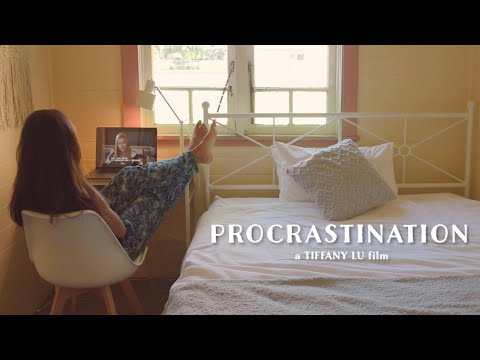

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("O3XBoC7bXso", width=640, height=360)

## 👉 **Using LangChain**  

In [ ]:
%%time
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_vertexai import ChatVertexAI
from langchain_core.runnables import RunnableLambda

def _create_input_messages(*, video_uri:str, chunks:int=8, interval_secs:int=30):
    video_parts = []
    for start_offset in range(chunks):
        part = {
            "type": "media", "file_uri": video_uri, "mime_type": "video/mp4",
            "video_metadata": {
                "start_offset": {"seconds": start_offset * interval_secs},
                "end_offset": {"seconds": (start_offset+1) * interval_secs}
            }
        }
        video_parts.append(part)
    return [[HumanMessage(content=[human_part, vp])] for vp in video_parts]

human_part = {"type": "text", "text": "Provide a summary of the video."}  ## ⚠️ Uniform prompt for chunks
input_messages = _create_input_messages(video_uri=video_uri)
## https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-0-flash
llm = ChatVertexAI(
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials           ## ✅ mandatory
)
chain = llm | StrOutputParser()
# summaries = chain.batch(input_messages, config={"max_concurrency": 3})
create_inputs_chain = RunnableLambda(lambda x: _create_input_messages(**x))
map_chain = create_inputs_chain | RunnableLambda(lambda x: chain.batch(x, config={"max_concurrency": 4}))
summaries = map_chain.invoke({"video_uri": video_uri})

CPU times: user 9.36 s, sys: 1.29 s, total: 10.7 s
Wall time: 25.6 s


Let's define a function to merge summaries together:

In [ ]:
%%time
from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown, display

def _merge_summaries(summaries:list[str], interval_secs:int=10, **kwargs) -> str:
    sub_summaries = []
    for i, summary in enumerate(summaries):
        sub_summary = (
            f"Summary from sec {i*interval_secs} to sec {(i+1)*interval_secs}:"
            f"\n{summary}\n")
        sub_summaries.append(sub_summary)
    return "".join(sub_summaries)

reduce_prompt = PromptTemplate.from_template(
    "You are given a list of summaries that "
    "of a video splitted into sequential pieces.\n"
    "SUMMARIES:\n{summaries}"
    "Based on that, prepare a summary of a whole video."
)
reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | reduce_prompt | llm | StrOutputParser()
final_summary = reduce_chain.invoke({"summaries": summaries})
display(Markdown(final_summary))

This video, titled "Procrastination," follows a young woman named Tiffany Lu as she struggles to write a 3000-word research paper on Quantum Theory. The video opens with her waking up and attempting to start her research, but she quickly gets overwhelmed. Over the next several segments, we see her engage in various procrastination techniques. These include drinking tea and eating snacks (chocolate and cinnamon sticks), browsing the internet, using her phone, and lounging in bed. She also prepares and eats avocado toast.

A montage depicts moments of frustration and distraction, interspersed with shots of clocks showing the passage of time. We also see glimpses of her getting ready for the day, including tying her shoes.

The video then shifts to a segment where she is in the bathtub. Her emotional state fluctuates; she expresses anger, sings along to music, becomes upset, relaxes, and then dramatically spits into the air and submerges herself.

The video explicitly acknowledges its theme by showing the title "Procrastination" alongside a blinking cursor. We see her decide to avoid the task at hand and shut her laptop. The final segment shows her sitting in her bedroom, watching music videos on her laptop, specifically listening to a playlist of songs like "I Will Survive," "I Will Always Love You," "Dancing on My Own," "Dancing Queen," and "It’s My Life." The video concludes with the room gradually darkening as she continues to procrastinate and listen to music. The credits indicate that Tiffany Lu wrote, filmed, and edited the video, implying it is based on a true story.


CPU times: user 13.2 ms, sys: 3.72 ms, total: 17 ms
Wall time: 2.65 s


Let's implement a reduce step that merges intermediatesummaries together:

In [ ]:
%%time
from langchain_core.runnables import RunnablePassthrough
reduce_chain = (
    RunnableLambda(lambda x: _merge_summaries(**x)) |
    reduce_prompt | llm | StrOutputParser()
)
final_chain = (
    RunnablePassthrough.assign(summaries=map_chain).assign(final_summary=reduce_chain) |
    RunnableLambda(lambda x: x["final_summary"])
)
result = final_chain.invoke({
    "video_uri": video_uri, "interval_secs": 30, "chunks": 8})
result

CPU times: user 87.6 ms, sys: 16 ms, total: 104 ms
Wall time: 11.3 s


'This video depicts a young woman\'s struggle with procrastination while trying to write a 3000-word research paper on quantum theory.\n\nThe video opens with her morning routine, transitioning to her facing the daunting task. We see her preparing tea and attempting to research the topic, but quickly becoming frustrated and distracted. The video highlights her procrastination, showing her wasting time on her phone and other activities, while the clock ticks away. She has breakfast at 2pm.\n\nOverwhelmed, she takes a break, skateboarding, then returns home and relaxes in a bathtub, singing and crying. After her bath, she returns to the task at hand, eventually deciding to postpone it until the next day. The video ends with her listening to upbeat music and the title card "Procrastination," revealing it\'s a film based on a true story by Tiffany Lu.\n'

In [ ]:
display(Markdown(result))

This video depicts a young woman's struggle with procrastination while trying to write a 3000-word research paper on quantum theory.

The video opens with her morning routine, transitioning to her facing the daunting task. We see her preparing tea and attempting to research the topic, but quickly becoming frustrated and distracted. The video highlights her procrastination, showing her wasting time on her phone and other activities, while the clock ticks away. She has breakfast at 2pm.

Overwhelmed, she takes a break, skateboarding, then returns home and relaxes in a bathtub, singing and crying. After her bath, she returns to the task at hand, eventually deciding to postpone it until the next day. The video ends with her listening to upbeat music and the title card "Procrastination," revealing it's a film based on a true story by Tiffany Lu.


## 👉 Using LangGraph

Let's implement the same logic using LangGraph:

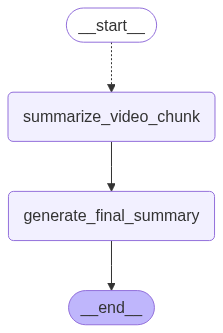

In [ ]:
import operator
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    video_uri: str
    chunks: int
    interval_secs: int
    summaries: Annotated[list, operator.add]
    final_summary: str

class _ChunkState(TypedDict):
    video_uri: str
    start_offset: int
    interval_secs: int

## ⚠️ I'm not sure if the model takes the metadata into account during summarization.
# human_part = {"type": "text", "text": "Provide a summary of the video."}

async def _summarize_video_chunk(state:  _ChunkState):
    start_offset = state["start_offset"]
    interval_secs = state["interval_secs"]
    start_sec = start_offset * interval_secs
    end_sec = (start_offset+1) * interval_secs
    human_part = {
        "type": "text",
        ## ⚠️ Prompt to include time information in chunck summaries
        "text": f"Provide a summary of the video between seconds {start_sec} and {end_sec}. "
                f"Include time-stamped descriptions along with the summary."
    }
    video_part = {
        "type": "media", "file_uri": state["video_uri"], "mime_type": "video/mp4",
        "video_metadata": {
            "start_offset": {"seconds": start_sec},
            "end_offset": {"seconds": end_sec},
        }
    }
    response = await llm.ainvoke(
        [HumanMessage(content=[human_part, video_part])])
    return {"summaries": [response.content]}

def _map_summaries(state: AgentState):
    chunks = state["chunks"]
    payloads = [
        {
            "video_uri": state["video_uri"],
            "interval_secs": state["interval_secs"],
            "start_offset": i
        } for i in range(state["chunks"])
    ]
    return [Send("summarize_video_chunk", payload) for payload in payloads]

async def _generate_final_summary(state: AgentState):
    summary = _merge_summaries(
        summaries=state["summaries"], interval_secs=state["interval_secs"])
    final_summary = await (reduce_prompt | llm | StrOutputParser()).ainvoke({"summaries": summary})
    return {"final_summary": final_summary}

graph = StateGraph(AgentState)
graph.add_node("summarize_video_chunk", _summarize_video_chunk)
graph.add_node("generate_final_summary", _generate_final_summary)

graph.add_conditional_edges(START, _map_summaries, ["summarize_video_chunk"])
graph.add_edge("summarize_video_chunk", "generate_final_summary")
graph.add_edge("generate_final_summary", END)

app = graph.compile()
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [ ]:
result = await app.ainvoke(
    {"video_uri": video_uri, "chunks": 8, "interval_secs": 30},
    {"max_concurrency": 3}
)
result["final_summary"]

'This video portrays a young woman\'s relatable struggle with procrastination while trying to write a research paper on Quantum Theory.\n\nThe video opens with a sunny morning and the woman waking up, starting her day with brushing her teeth and working on her laptop at 5:50 AM. She tries to get motivated, even biting a cinnamon stick and making tea. Despite her efforts, visible on the laptop screen showing "Research Paper: Quantum Theory" increasing from 300 to 3000 words, she seems stuck.\n\nThe scene transitions to later in the day, almost 2:30 PM.  The woman is shown looking unmotivated, tapping a pencil against her desk. She grabs her phone, smiles while on her bed, and generally avoids working.  She prepares avocado toast, further delaying the task.  The time jumps to 3:20 PM, and she\'s still making silly faces instead of writing.\n\nFrustrated, she appears to need a break.  She goes skateboarding, fills a bathtub, lights a candle and tries to relax. But her emotions bubble to t

In [ ]:
display(Markdown(result['final_summary']))

This video portrays a young woman's relatable struggle with procrastination while trying to write a research paper on Quantum Theory.

The video opens with a sunny morning and the woman waking up, starting her day with brushing her teeth and working on her laptop at 5:50 AM. She tries to get motivated, even biting a cinnamon stick and making tea. Despite her efforts, visible on the laptop screen showing "Research Paper: Quantum Theory" increasing from 300 to 3000 words, she seems stuck.

The scene transitions to later in the day, almost 2:30 PM.  The woman is shown looking unmotivated, tapping a pencil against her desk. She grabs her phone, smiles while on her bed, and generally avoids working.  She prepares avocado toast, further delaying the task.  The time jumps to 3:20 PM, and she's still making silly faces instead of writing.

Frustrated, she appears to need a break.  She goes skateboarding, fills a bathtub, lights a candle and tries to relax. But her emotions bubble to the surface, and she yells in despair. Then she is singing along to music, the scene is playful, she even sticks her middle fingers up. She submerges herself fully in the water, suggesting a desire to escape.  Another woman enters the bathroom, looking directly at the camera, adding a somewhat mysterious element to the narrative.

The final part of the video shows her further giving in to procrastination. A black line with an hourglass appears on the computer screen, symbolizing the passing of time. She says "Yeah, I'll do it tomorrow" and closes her computer. Then, she's at her desk watching a video titled "Procrastination. Based on true story." Finally, the screen displays a playlist of upbeat and defiant songs, reinforcing her avoidance and desire to escape the task, before the screen fades to black. The video is a humorous and honest depiction of the procrastination cycle, highlighting the emotional rollercoaster it can be.


In [ ]:
## executing the LangGraph app again
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 8, "interval_secs": 30},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['generate_final_summary']


In [30]:
## executing the LangGraph app again
chunk_summaries = []
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 8, "interval_secs": 30},
    {"recursion_limit": 50},
):
    # print(list(step.values()))
    for val in step.values():
        if isinstance(val, dict) and "summaries" in val:
            chunk_summaries.append(val["summaries"][0])

In [31]:
md = ""
for i, chunk_summary in enumerate(chunk_summaries):
    # Replace newlines with <br> for wrapping
    md_summary = str(chunk_summary).replace('\n', '<br>')
    md += f"**{i}.**<br>{md_summary}<br><br>"
display(Markdown(md))

**0.**<br>Here is a summary of the video between seconds 150 and 180, with time-stamped descriptions:<br><br>The woman, sitting in a bathtub with her hair up in a bun, begins singing to the music. She is animated while singing (2:30). She then punches the air a few times to the music, throws her hair, and gives the camera the middle finger (2:41). At (2:51) she leans on the tub, looking at the camera, with a serious expression, then jumps back and puts her head underwater (2:56). The camera flashes to a hallway before the woman exits the bathroom and looks directly at the camera (2:58).<br><br>**1.**<br>Okay! Here's a summary of the video between 0 and 30 seconds:<br><br>The video starts with a shot of the sun shining through a tree in the morning. A woman wakes up in her bedroom (0:02), gets out of bed, and brushes her teeth (0:13 - 0:16). She sits down at a desk and opens up a laptop, looking at a document titled "Research Paper: Quantum Theory (3000 words)". (0:17 - 0:22) A close-up of her face shows her chewing on a stick, and a shot of a clock showing it is 7:25 am. (0:23 - 0:30).<br><br>**2.**<br>Okay, here is a summary of the video from seconds 120 to 150, along with time-stamped descriptions:<br><br>*   **0:02:00 - 0:02:07**: The video cuts to a close up of a skateboarder's feet and board. They ride down the street in front of a house and then attempt to do a trick on the board.<br>*   **0:02:08 - 0:02:11**: A hand reaches up to turn on the faucet in a bathtub.<br>*   **0:02:11 - 0:02:12**: The hand lights a lighter.<br>*   **0:02:12 - 0:02:30**: A woman is shown sitting in the bathtub and singing. She then leans forward and looks sad.<br><br>**3.**<br>Here's a summary of the video between seconds 30 and 60, with time-stamped descriptions:<br><br>**Summary:** The woman begins a session of studying for Quantum Theory. She does this by putting a small piece of cinnamon into her mouth. She then starts the process of making a cup of tea. She then looks at the research paper that is on quantum theory and the camera shows that she is researching quantum theory on the internet.<br><br>*   0:30-0:33 A woman is shown putting a small piece of cinnamon into her mouth.<br>*   0:34-0:40 The woman begins to prepare a cup of tea.<br>*   0:41-0:53 The title of the woman's research paper is displayed, and she begins researching quantum theory on the internet.<br>*   0:54-0:59 The woman looks up at the ceiling.<br><br>**4.**<br>Here is a summary of the video from seconds 60 to 90, with time stamps.<br><br>From [00:01:00] to [00:01:06], there are close up shots of the face of a woman and the words "Research Paper: Quantum Theory" on a computer screen. From [00:01:07] to [00:01:09], a wooden pencil is shown and the woman's face again. A phone is shown at [00:01:11] to [00:01:13]. From [00:01:14] to [00:01:20], a girl is on a bed looking at her phone. She moves around and smiles, and then does leg lifts. From [00:01:21] to [00:01:23] a close up is shown of the woman's face with the wooden pencil. From [00:01:23] to [00:01:26] are images of the computer screen again and a clock, and from [00:01:29] to [00:01:29] a final shot of the woman is shown.<br><br>**5.**<br>Okay, here is a summary of the video between seconds 90 and 120, with time stamps.<br><br>The subject is hurrying to get ready.<br><br>[00:01:32-00:01:33] Two pieces of toast pop up out of the toaster.<br>[00:01:34-00:01:35] A stovetop burner is lit and a frying pan is placed on top of it.<br>[00:01:36-00:01:37] Someone spreads avocado on top of the toast.<br>[00:01:38-00:01:39] Time on a clock shows it is almost 2 o'clock.<br>[00:01:41-00:01:41] The subject is looking at the camera with a pencil on their forehead.<br>[00:01:43-00:01:44] The pencil is resting in the same place as the subject thinks.<br>[00:01:47-00:01:48] Time on a clock shows that it is almost 3 o'clock.<br>[00:01:50-00:01:51] Subject places the pencil between their nose and top lip.<br>[00:01:52-00:01:53] They zip up their jeans.<br>[00:01:53-00:02:00] They tie their shoelaces on their tennis shoes.<br><br>**6.**<br>Okay, here is a summary of the video between seconds 210 and 240, with time-stamped descriptions:<br><br>The video continues with the same setting as the previous frames, showcasing a woman sitting at a desk with a laptop playing a video.  The window behind her provides natural light. During this period, more song titles and artist information are displayed on the screen.<br><br>*   **0:02:10 - 0:02:15** The title "I WILL ALWAYS LOVE YOU" with the words written by Dolly Parton and performed by Whitney Houston are displayed.<br><br>*   **0:02:16 - 0:02:22** The title "DANCING ON MY OWN" with the words written by Patrik Berger, Robin Carlsson, Stig Anderson, and performed by Calum Scott are displayed.<br><br>*   **0:02:23 - 0:02:29** The title "DANCING QUEEN" with the words written by Benny Andersson, Björn Ulvaeus, Stig Anderson, and performed by Christine Baranski, Julie Walters, and Meryl Streep are displayed.<br><br>*   **0:02:30 - 0:02:40** The title "IT'S MY LIFE" with the words written by Jon Bon Jovi, Martin Sandberg, Richie Sambora, and performed by Bon Jovi are displayed. The girl rests her feet on the window frame.<br><br><br>**7.**<br>Okay, here's the summary of the video between seconds 180 and 210.<br><br>The woman with long hair is struggling to start writing.<br>* At [00:03:00], the video shows the woman looking at the camera.<br>* At [00:03:01], the video shifts to a blank page on the laptop with a cursor blinking.<br>* At [00:03:03], the video goes back to the woman looking at the camera with a pencil in her mouth.<br>* At [00:03:05], the video shows a close up of a wall clock with the hands moving.<br>* At [00:03:08], the video goes back to the woman looking at the camera with a pencil in her mouth.<br>* At [00:03:11], the video shifts to a blank page on the laptop with a cursor blinking.<br>* At [00:03:13], the woman again puts a pencil to her lips.<br>* At [00:03:15], she says, "Yeah, I'll do it tomorrow!".<br>* At [00:03:16], the woman closes her laptop.<br>* At [00:03:18], the video displays the title "Procrastination" with the words, "Based on true story" under it. The woman sits at her desk and watches a show on the laptop. Additional credits appear as the woman watches a show on her laptop.<br><br>

Let's look at the final summary:

In [32]:
display(Markdown(list(step.values())[0]['final_summary']))
## The final summary is more time specific.

Okay, here is a summary of the entire video, based on the provided summaries:

The video opens with a morning scene of sunlight through trees. A woman wakes up, brushes her teeth, and sits down at her desk to work on a research paper about Quantum Theory. She prepares tea and researches the topic online. She struggles to focus, fiddling with a pencil and looking at her phone.

As time passes (clocks showing 7:25 AM, then later almost 2 and 3 PM), she hurries to make toast with avocado. She appears distracted, putting a pencil on her forehead and between her lip and nose, showing her procrastination.

Later, she's seen skateboarding (though only feet and board are shown) and then relaxing in a bathtub, singing along to music. Her mood shifts from animated and rebellious (giving the camera the middle finger) to pensive and sad, even briefly submerging her head.

After exiting the bathroom, the video returns to her struggle to write. She stares at a blank page, puts a pencil in her mouth, and watches the clock ticking. Finally, she gives up, declaring "Yeah, I'll do it tomorrow!" She closes her laptop.

The title card "Procrastination: Based on a True Story" appears, and the remainder of the video shows her watching a show on her laptop while credits (and presumably more songs) roll by. The video displays the title "I WILL ALWAYS LOVE YOU" written by Dolly Parton and performed by Whitney Houston. Then, the title "DANCING ON MY OWN" written by Patrik Berger, Robin Carlsson, Stig Anderson, and performed by Calum Scott are displayed. Finally, the titles "DANCING QUEEN" and "IT'S MY LIFE" are displayed. During this period, the girl rests her feet on the window frame.
